## Локальный и глобальный поиск

Во всех задачах нужно визуализировать минимальный путь и вывести его длину. 
Путь не циклический - начинается и заканчивается в разных точках.

ВНИМАНИЕ: расстояние нужно считать как L1, отрисовывать тоже как L1.

1. (1 балл) Реализуйте Монте-Карло поиск.
2. (1 балл) Реализуйте поиск случайным блужданием.
3. (2 балла) Реализуйте Hill Climb.
4. (3 балла) Реализуйте ожиг (simulated annealing). Температурный режим отжига выберите самостоятельно.
5. (3 балла) Реализуйте генетический алгоритм. 


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from copy import copy
from matplotlib.path import Path
from matplotlib.patches import PathPatch

### Read dataset

In [2]:
df = pd.read_csv('hw1/tsp.csv', header=None, index_col=0, names=['X', 'Y'])
X = df.X.values
Y = df.Y.values
D = df.values

In [3]:
print(df.head())

     X    Y
1  565  575
2   25  185
3  345  750
4  945  685
5  845  655


### Supplementary functions

In [4]:
def get_distance(D, path):
    D = D[path]
    X, Y = D[:,0], D[:,1]
    return np.sum(np.abs(X[1:] - X[:-1]) + np.abs(Y[1:] - Y[:-1]))

def make_path(D, path):
    D = D[path]
    x0, y0 = D[0, :]
    verts = [(x0, y0)]
    for x, y in D[1:]:
        verts.append((x, y0))
        verts.append((x, y))
        x0, y0 = x, y
    return verts

def plot_path(D, path):
    codes = [Path.MOVETO] + [Path.LINETO]*2*(len(X)-1) 
    vertices = make_path(D, path)

    vertices = np.array(vertices, float)
    line_path = Path(vertices, codes)

    pathpatch = PathPatch(line_path, facecolor='None', edgecolor='green')

    fig, ax = plt.subplots(figsize=(20,20))
    ax.add_patch(pathpatch)
    ax.autoscale_view()
    ax.scatter(X, Y)
    
    plt.title(f'Best path with distance: {get_distance(D, path)}')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

### 1. Monte Carlo

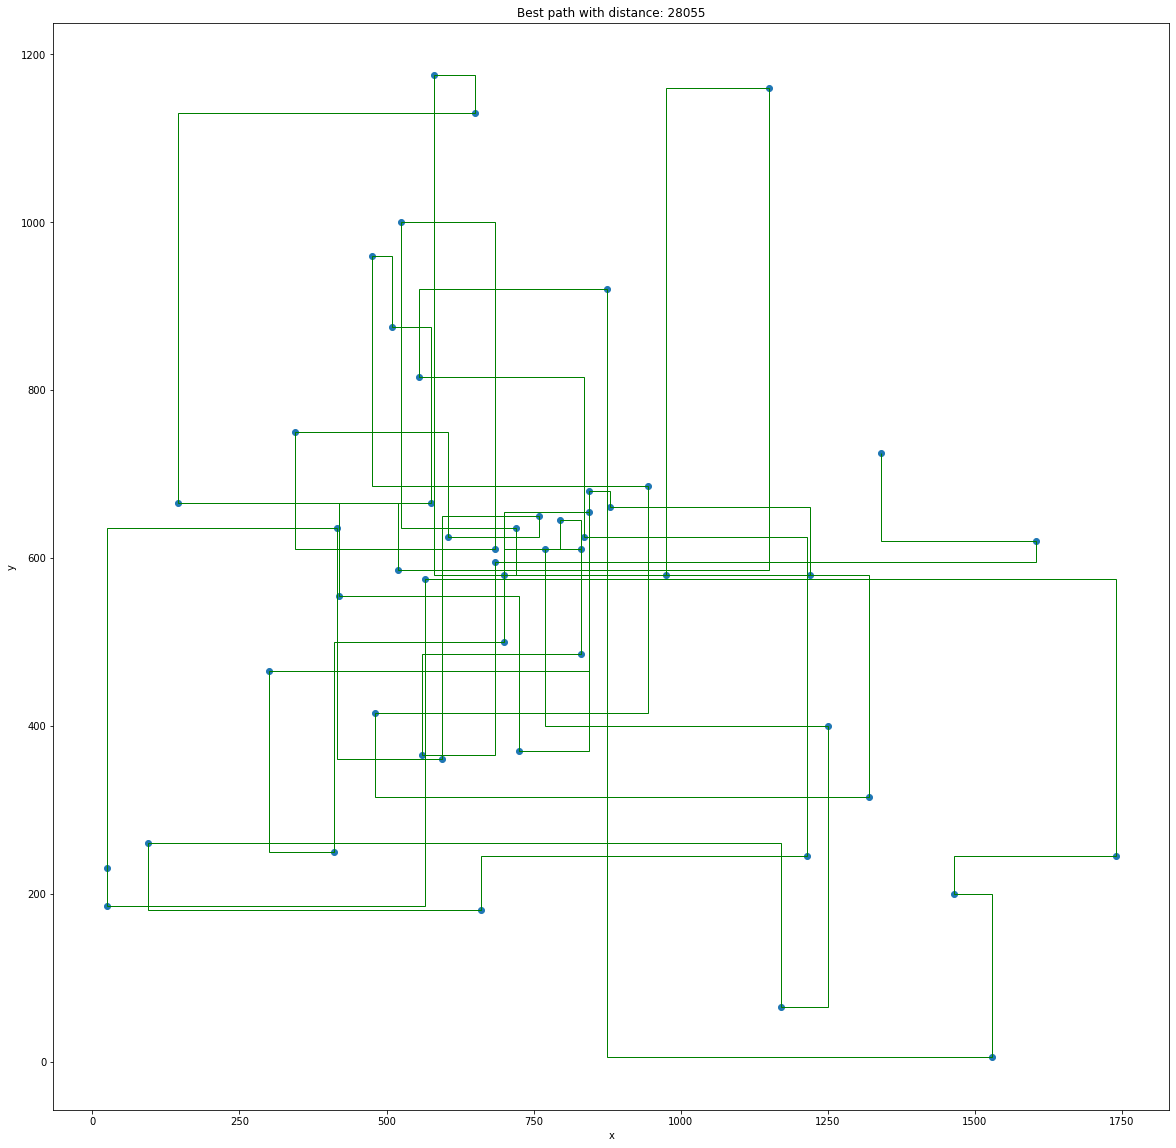

In [5]:
def monte_carlo_search(D, n_iter=100000):
    n = len(D)
    distance = np.inf
    idx = np.arange(n)
    for _ in range(n_iter):
        new_idx = np.random.permutation(idx)
        dist = get_distance(D, new_idx)
        if dist < distance:
            distance = dist
            idx = new_idx
    return idx


path = monte_carlo_search(D)
plot_path(D, path)

### 2. Random walk

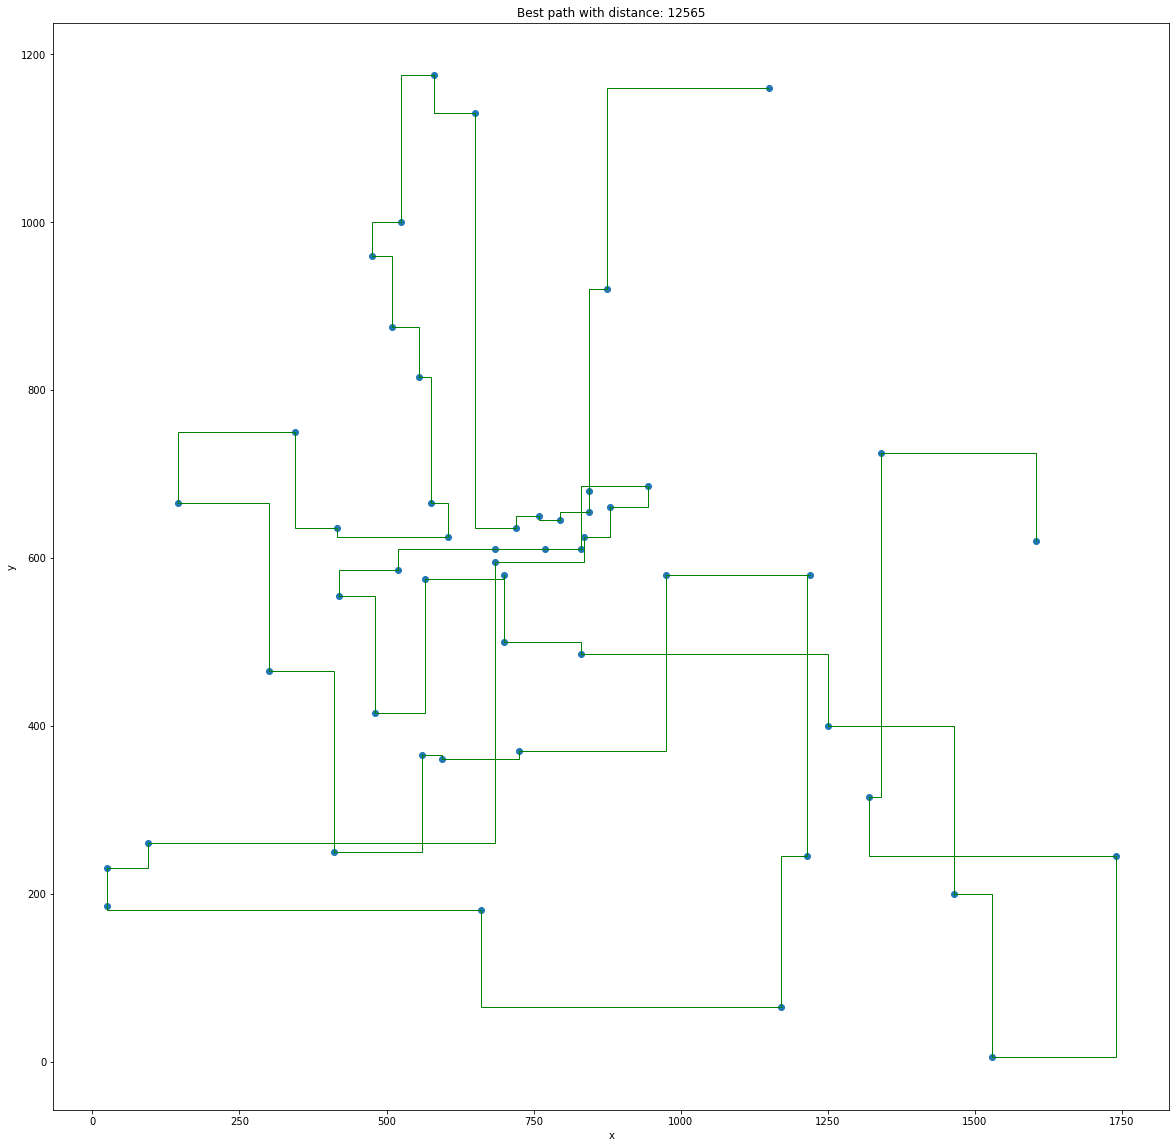

In [6]:
def random_walk(D, n_iter=100000):
    n = len(D)
    distance = np.inf
    idx = np.arange(n)
    for _ in range(n_iter):
        new_idx = copy(idx)
        left, right = np.random.choice(n, 2, replace=False)
        new_idx[left], new_idx[right] = new_idx[right], new_idx[left]
        dist = get_distance(D, new_idx)
        if dist < distance:
            distance = dist
            idx = copy(new_idx)
    return idx


path = random_walk(D)
plot_path(D, path)

### 3. Hill Climb.

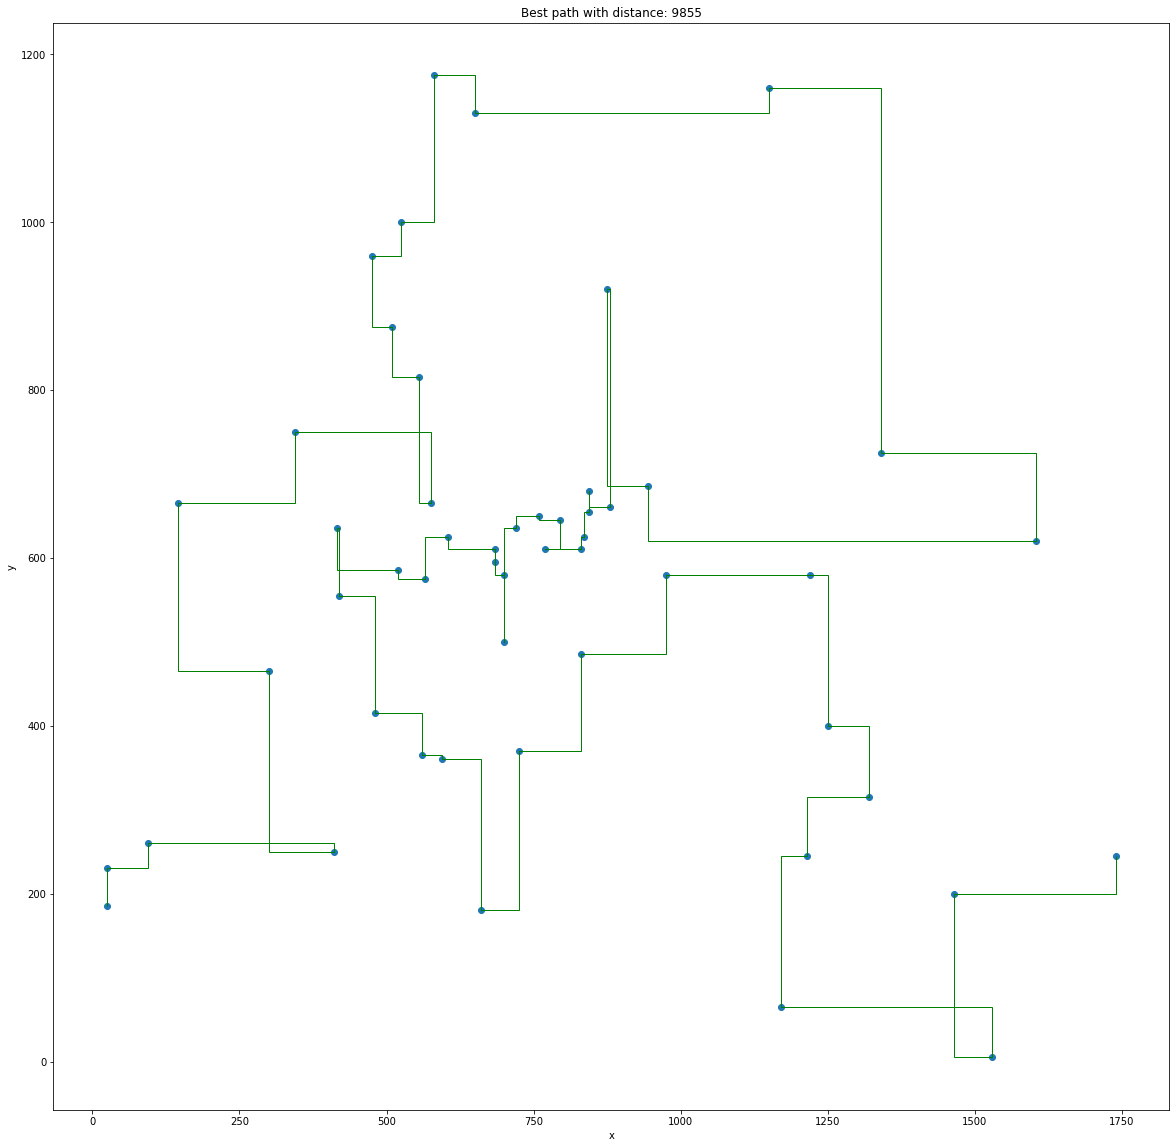

In [7]:
def hill_climb(D, n_iter=10000):
    n = len(D)
    distance = np.inf
    idx = np.arange(n)
    for _ in range(n_iter):
        left = np.random.randint(n)
        best_idx = np.arange(n)
        best_dist = np.inf
        for right in range(n):
            new_idx = copy(idx)
            new_idx[left:right] = new_idx[left:right][::-1]
            dist = get_distance(D, new_idx)
            if dist < best_dist:
                best_dist, best_idx = dist, new_idx
        distance, idx = best_dist, best_idx
    return idx


path = hill_climb(D)
plot_path(D, path)

### 4. Simulated annealing

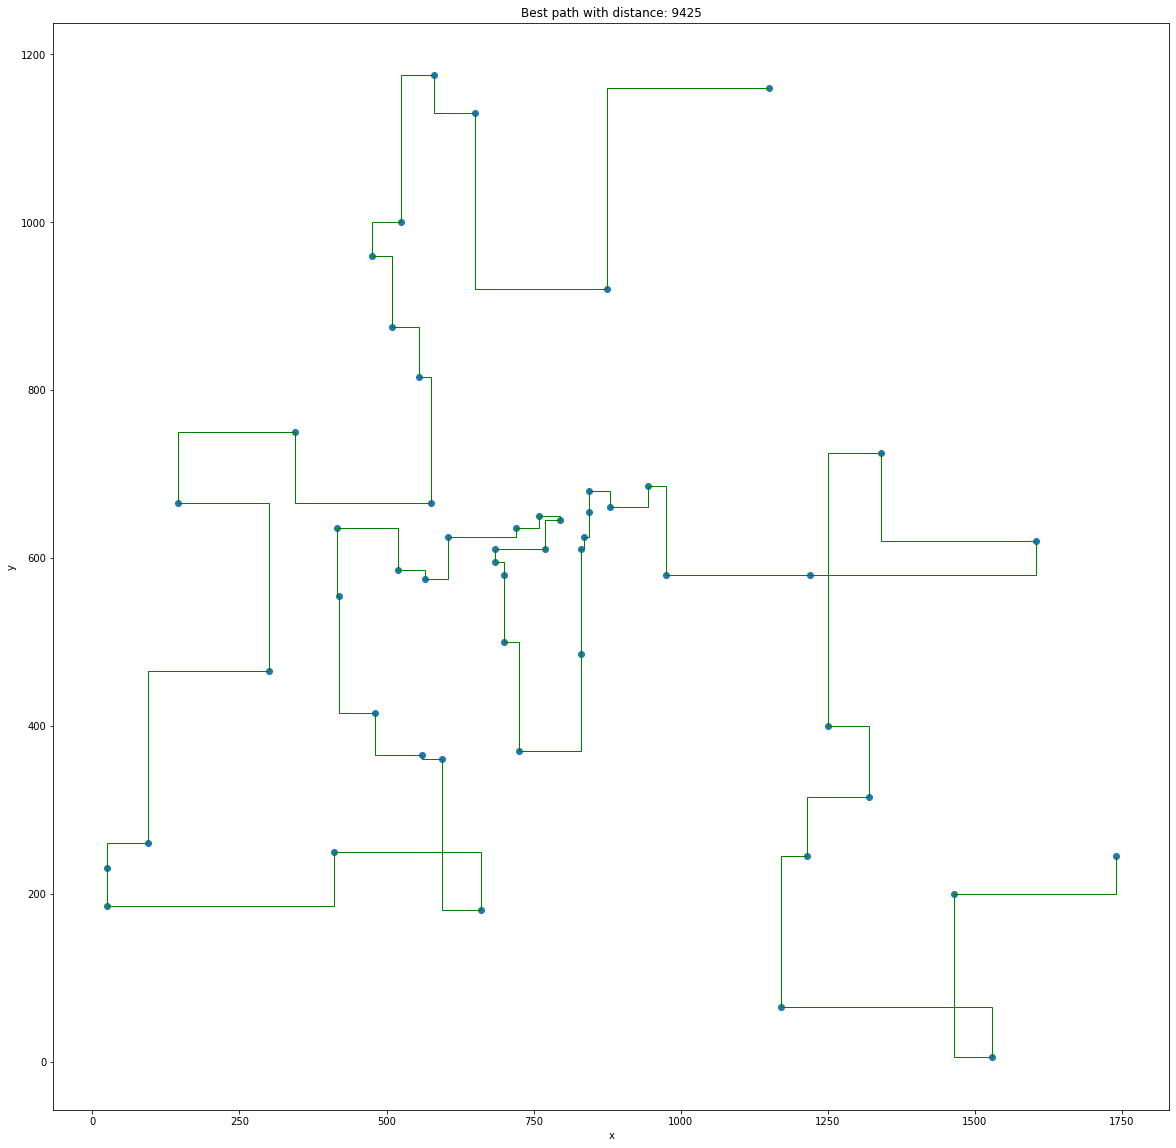

In [8]:
def simulated_annealing(D, n_iter=100000):
    n = len(D)
    idx = np.arange(n)
    distance = get_distance(D, idx)
    t = 10
    dt = t / n_iter
    
    for _ in range(n_iter):
        left = np.random.randint(n)
        right = np.random.randint(n)
        new_idx = copy(idx)
        new_idx[left:right] = new_idx[left:right][::-1]
        dist = get_distance(D, new_idx)
        if (dist < distance) or (np.random.uniform() < np.exp((distance - dist)/t)):
            distance, idx = dist, new_idx
        t -= dt
    return idx


path = simulated_annealing(D)
plot_path(D, path)

### 5. Genetic algorithm

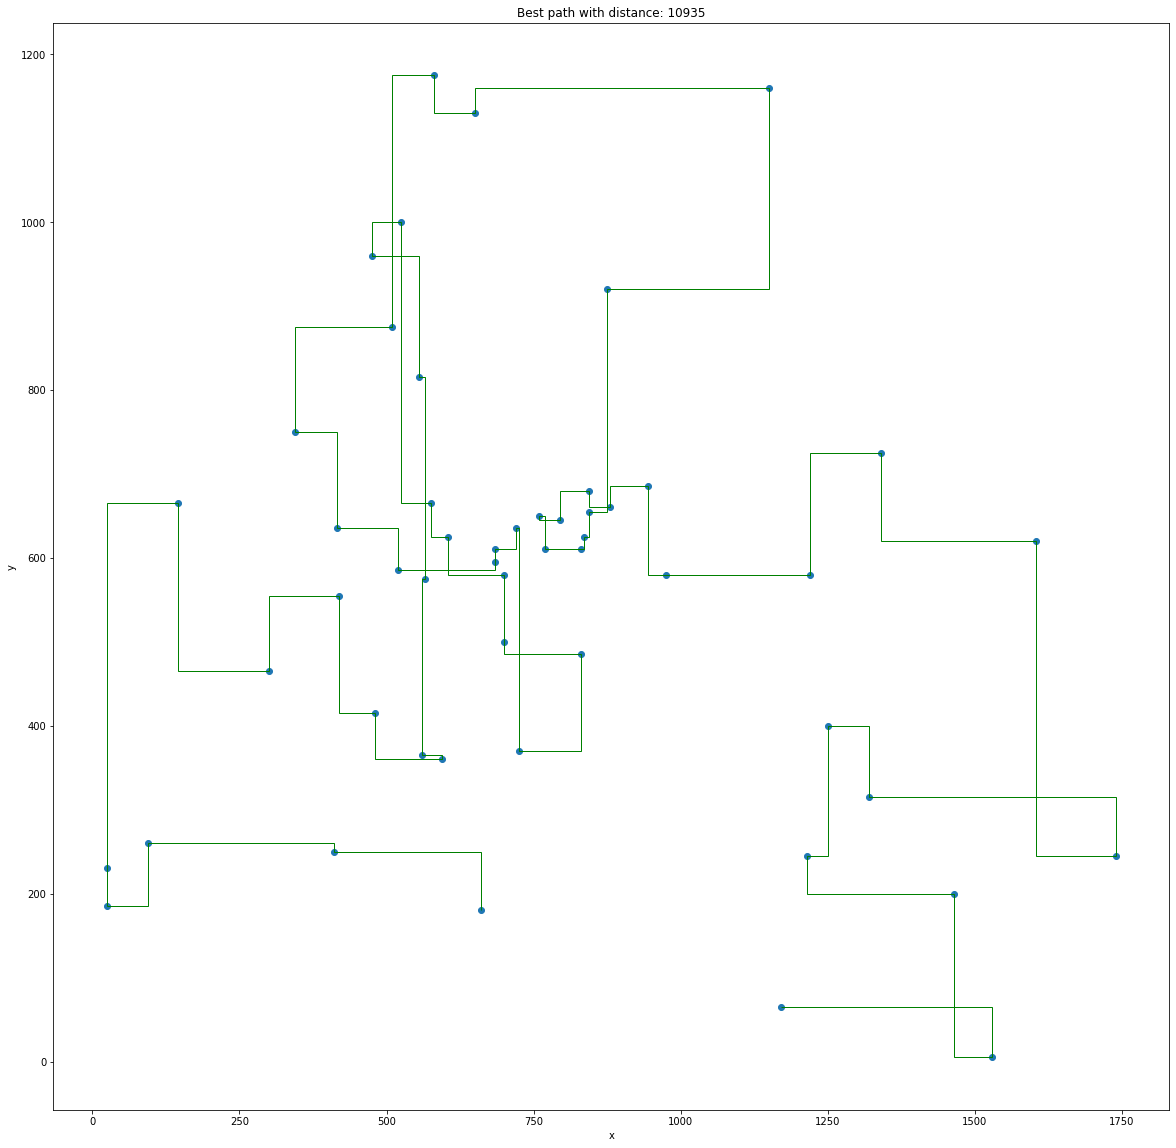

In [9]:
def select_parents(population, fitness):
    fitness = np.array(fitness)
    pop_size = len(population)
    first, second = np.random.choice(np.arange(pop_size), 2, p=fitness/fitness.sum(), replace=False)
    return population[first], population[second]

def crossover(parent1, parent2):
    n = len(parent1)
    left, right = np.sort(np.random.randint(0, n, 2))
    child = np.zeros(n, dtype=np.int)
    parent_segment = parent1[left:right]
    child[left:right] = parent_segment
    pos = right
    for i in range(n):
        if parent2[i] not in parent_segment:
            child[pos] = parent2[i]
            pos = (pos + 1) % n 
    return child

def mutate(child, p=0.07):
    if np.random.random() < p:
        n = len(child)
        left, right = np.sort(np.random.randint(0, n, 2))
        child[left:right] = child[left:right][::-1]
    return child

def ga(D, n_iter=100000, pop_size=50):
    n = len(D)
    idx = np.arange(n)
    population = [np.random.permutation(idx) for _ in range(pop_size)]
    fitness = [get_distance(D, sample) for sample in population]
    
    for i in range(n_iter):
        # parent selection
        parent1, parent2 = select_parents(population, fitness)
        # crossover with probability pc
        child1, child2 = crossover(parent1, parent2), crossover(parent2, parent1)
        # mutation with probability pm
        child1, child2 = mutate(child1), mutate(child1)
        # decode and fitness calculation
        population.extend([child1, child2])
        fitness.extend([get_distance(D, child1), get_distance(D, child2)])
        # survivor selection
        min1 = max(range(pop_size + 2), key=lambda x: fitness[x])
        population.pop(min1)
        fitness.pop(min1)
        min2 = max(range(pop_size + 1), key=lambda x: fitness[x])
        population.pop(min2)
        fitness.pop(min2)
        
    # find best
    idx = population[min(range(pop_size), key=lambda x: fitness[x])]
    return idx

path = ga(D)
plot_path(D, path)